<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/labeled_image-demo-BLIP-2/image_labeling_BLIP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labeling a dataset using BLIP-2

In this notebook, we will demonstrate how to create a labeled dataset using BLIP-2 and push it to the Hugging Face hub.  BLIP-2, which does zero-shot image-to-text generation, was introduced in [BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models](https://arxiv.org/pdf/2301.12597.pdf) by Li, et. al. BLIP-2 bootstraps frozen pre-trained image and LLMs, bridging the modality gap with a Querying Transformer (Q-Former). You can read more about BLIP-2 [here](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/blip-2).

Notes:

* It's advised to run this notebook on a GPU environment, high RAM.

* This notebook was adapted from [here](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BLIP-2/Chat_with_BLIP_2_%5Bint8_bitsandbytes%5D.ipynb).

Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [ ]:
!apt-get install git-lfs

First, let's install the dependencies.

In [1]:
!pip install -q accelerate bitsandbytes datasets huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


Let's log into the Hugging Face hub with our "WRITE" access token.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

We need CUDA to run this notebook.

In [3]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Image captioning

We are using the BLIP-2 model and its corresponding processor. We will load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters. Note that while we will use 8-bit inference using Bitsandbytes--which greatly reduces the memory requirements--you can use other dtypes. You can learn more about the model [here](https://huggingface.co/Salesforce/blip2-opt-2.7b).



In [4]:
import os
import requests
from PIL import Image
from io import BytesIO
from transformers import AutoProcessor, Blip2ForConditionalGeneration

# We will grab some images from the hf-vison course-assets
url = "https://huggingface.co/datasets/hf-vision/course-assets/resolve/main/label_dataset_owlv2"

# Alternately, you can load images from a local folder
# path = ""

# Set the number of images to label
num_images = 10

# Add a prompt to indicate how you want to label the image
# Since we are generating a generic label, we could leave out the text prompt (the model will by default start generating text from the BOS (beginning-of-sequence) token)
prompt = "this is a photo of"


# Write a function to add images to the dataset
def add_images(idx):
    #  Instantiate the model and its corresponding processor
    processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True
    )

    # Get the URL for an image
    image_url = f"{url}/{idx}.jpeg"

    # Download the image
    response = requests.get(image_url)
    image_content = response.content

    # Open the image using PIL
    image = Image.open(BytesIO(image_content))

    inputs = processor(image, text=prompt, return_tensors="pt").to(
        device, torch.float16
    )

    generated_ids = model.generate(**inputs, max_new_tokens=20)
    label = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # Alternately, you can load images from a local folder
    # image = Image.open(f'{path}/{idx}.jpeg')

    # Add image and label to the dataset
    return {
        "image": image,
        "label": label,
    }


def generate_entries():
    for i in range(num_images):
        yield add_images(i)

We are now ready to push our dataset to the Hugging Face hub. We have a couple of options on how to do this.

* Use an image folder with a metajsonl file
* Use a generator

We are going to demo using the generator method, which is a memory-efficient way to create a dataset because it iterates through the images. You can read more about adding a dataset [here](https://huggingface.co/docs/datasets/en/create_dataset).


In [5]:
from datasets import Dataset

username = "kfahn"
repo_id = "labeled_images_demo_BLIP2"

# Create a dataset from the generator
ds = Dataset.from_generator(generate_entries)
ds.push_to_hub(f"{username}/{repo_id}")

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/307 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/labeled_images_demo_BLIP2/commit/48e43b11de9d4998d3fe91b68fcff2dfc61c6a52', commit_message='Upload dataset', commit_description='', oid='48e43b11de9d4998d3fe91b68fcff2dfc61c6a52', pr_url=None, pr_revision=None, pr_num=None)

Let's check out our new dataset by downloading it from the hub.

In [6]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("kfahn/labeled_images_demo_BLIP2")

Generating train split:   0%|          | 0/10 [00:00<?, ? examples/s]

Let's take a look at one of the images.

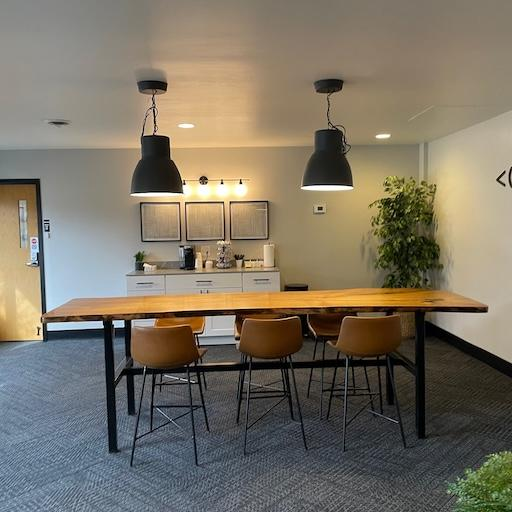

In [7]:
dataset["train"]["image"][0]

Now let's take a look at the label: it is 'a conference room with a table and chairs.' The model provided an accurate label!

In [8]:
dataset["train"]["label"][0]

'a conference room with chairs and a table'